In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

pandas, numpy – load and manipulate tabular data.

matplotlib – plotting actual vs predicted.

StandardScaler – normalize numeric inputs so the model trains better.

metrics – evaluate model (MAE, RMSE, R²).

TimeSeriesSplit – time‑aware cross‑validation (no data leakage).

RandomizedSearchCV – quick hyper‑parameter tuning.

XGBRegressor – the XGBoost model.

scipy.stats – random distributions for parameter search.

In [ ]:
# 1. LOAD & SORT
df = pd.read_csv("/content/aligned_stock_data.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")  # day‑month‑year
df = df.sort_values(['Date','Symbol']).reset_index(drop=True)


Purpose: Ensure the dataset is in strict chronological order per stock.

Why: Time‑series models must never see “future” data while training.

In [ ]:
# 2. BASIC TECHNICAL FEATURES
df['High_Low']     = df['High'] - df['Low']
df['Daily_Return'] = df.groupby('Symbol')['Close'].pct_change()
for w in [5, 10, 20]:
    df[f"MA{w}"] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(w).mean())

df['Next_Close'] = df.groupby('Symbol')['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)

Purpose: Add volatility (High_Low), momentum (Daily_Return), short‑/mid‑trend (MA5/10/20), and the target Next_Close.

Why: These technical indicators often drive price movement and improve model accuracy.

In [ ]:
# 3. ONE‑HOT ENCODE SYMBOL
df = pd.get_dummies(df, columns=['Symbol'], prefix='Sym', dtype='uint8')


Purpose: Convert categorical stock tickers into numeric 0/1 columns.

Why: XGBoost works with numeric input only; one‑hot keeps each stock separate.

In [ ]:
# 4. FEATURES & TARGET
num_cols = ['Open','High','Low','Close','Volume',
            'High_Low','Daily_Return','MA5','MA10','MA20']
sym_cols = [c for c in df.columns if c.startswith('Sym_')]
feature_cols = num_cols + sym_cols

X = df[feature_cols].values.astype('float32')
y = df['Next_Close'].values.astype('float32')

Why scale? Tree models don’t require scaling, but it balances split decisions and sometimes speeds training.

Inputs (feature_cols) hold all predictors.

In [ ]:
# SCALE ONLY NUMERIC FEATURES (optional but helps with tree depth)
scaler = StandardScaler()
X[:, :len(num_cols)] = scaler.fit_transform(X[:, :len(num_cols)])


In [ ]:
# 5. TIME‑BASED TRAIN / TEST SPLIT
cut = int(len(df) * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

Purpose: Train on older 80 % and test on the newest 20 %.

Why: Mimics real forecasting; no data leakage.

In [ ]:

# --- QUICK HYPER‑PARAM TUNE (random search) ---
param_dist = {
    'n_estimators'   : randint(200, 600), # trees
    'max_depth'      : randint(3, 8), # tree depth
    'learning_rate'  : uniform(0.03, 0.17),  # 0.03‑0.2 # Step Size
    'subsample'      : uniform(0.6, 0.4),    # 0.6‑1.0 # row sampling
    'colsample_bytree': uniform(0.6, 0.4), # col sampling
    'gamma'          : uniform(0, 2), # min loss reduction
    'min_child_weight': randint(1, 8) # min leaf weight
}

tscv = TimeSeriesSplit(n_splits=3)
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

rand_search = RandomizedSearchCV(
    xgb_base,
    param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
).fit(X_train, y_train)

best_xgb = rand_search.best_estimator_
print("Best XGB params:", rand_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'colsample_bytree': np.float64(0.6399899663272012), 'gamma': np.float64(0.9184977839317343), 'learning_rate': np.float64(0.08673046389363372), 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 508, 'subsample': np.float64(0.9879639408647978)}


In [ ]:
# 6. EVALUATE
y_pred = best_xgb.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"\nXGBoost Results:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.4f}")


XGBoost Results:
MAE  : 14.914
RMSE : 57.304
R²   : 0.8517


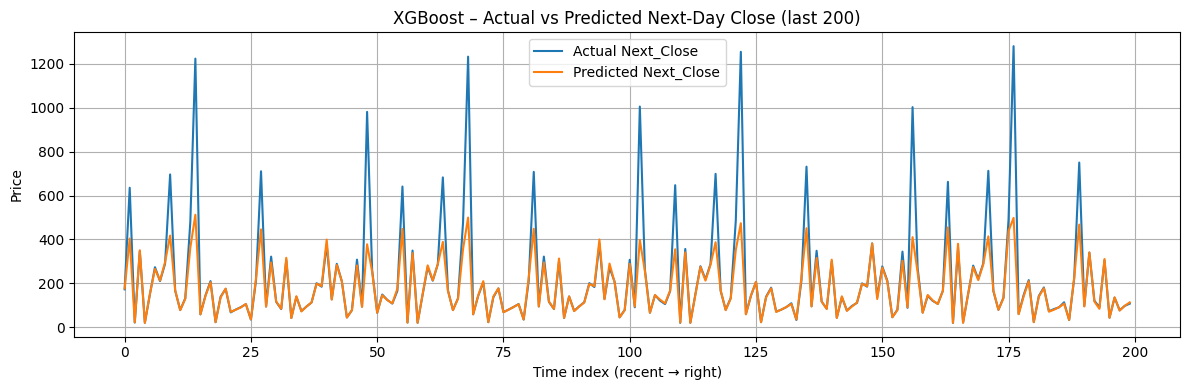

In [ ]:
# 7. PLOT last 200 points
n = 200 if len(y_test) >= 200 else len(y_test)
plt.figure(figsize=(12,4))
plt.plot(range(n), y_test[-n:], label='Actual Next_Close')
plt.plot(range(n), y_pred[-n:], label='Predicted Next_Close')
plt.title(f"XGBoost – Actual vs Predicted Next‑Day Close (last {n})")
plt.xlabel("Time index (recent → right)")
plt.ylabel("Price")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()